In [149]:
from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, make_scorer, precision_score, recall_score
from sklearn.model_selection import cross_validate

## Wczytywanie zbiorów

In [2]:
glass = fetch_ucirepo(id=42)
glass.data.features.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0


In [3]:
glass_dataset = pd.concat([glass.data.features, glass.data.targets], axis=1)
glass_dataset.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type_of_glass
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [4]:
with open("data/raw/polish_bankruptcy.pkl", "rb") as f:
    companies = pickle.load(f)

## Czyszczenie zbiorów

In [5]:
print("Null Value Counts in Glass Dataset:")
print("---------------------------------")
for column, count in glass_dataset.isnull().sum().items():
    print(f"{column:15} : {count}")

Null Value Counts in Glass Dataset:
---------------------------------
RI              : 0
Na              : 0
Mg              : 0
Al              : 0
Si              : 0
K               : 0
Ca              : 0
Ba              : 0
Fe              : 0
Type_of_glass   : 0


In [6]:
glass_dataset.duplicated().sum()

np.int64(1)

In [7]:
glass_dataset = glass_dataset.drop_duplicates()

In [8]:
companies.duplicated().sum()

np.int64(401)

In [9]:
companies = companies.drop_duplicates()

### Podział na zbiory treningowy/testowy

In [10]:
X_glass, y_glass = glass_dataset.iloc[:, :-1], glass_dataset.iloc[:, -1]
X_companies, y_companies = companies.iloc[:, :-1], companies.iloc[:, -1]
X_train_glass, X_test_glass, y_train_glass, y_test_glass = train_test_split(glass_dataset.iloc[:, :-1], glass_dataset.iloc[:, -1], test_size=0.2, stratify=glass_dataset.iloc[:, -1])
X_train_companies, X_test_companies, y_train_companies, y_test_companies = train_test_split(companies.iloc[:, :-1], companies.iloc[:, -1], test_size=0.2, stratify=companies.iloc[:, -1])
print(X_train_glass.shape)
print(X_test_glass.shape)
print(X_train_companies.shape)
print(X_test_companies.shape)

(170, 9)
(43, 9)
(34403, 65)
(8601, 65)


### Uruchomienie drzewa decyzyjnego dla domyślnych parametrów (oraz bez skalowanie i PCA)

a) glass

In [11]:
model = DecisionTreeClassifier()
model.fit(X_train_glass, y_train_glass)

DecisionTreeClassifier()

In [12]:
print("Głębokość drzewa:", model.get_depth())

Głębokość drzewa: 12



Test results:

Classification Report for Glass dataset:
              precision    recall  f1-score   support

           1       0.64      0.64      0.64        14
           2       0.77      0.67      0.71        15
           3       0.25      0.33      0.29         3
           5       0.75      1.00      0.86         3
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         6

    accuracy                           0.72        43
   macro avg       0.74      0.77      0.75        43
weighted avg       0.73      0.72      0.72        43



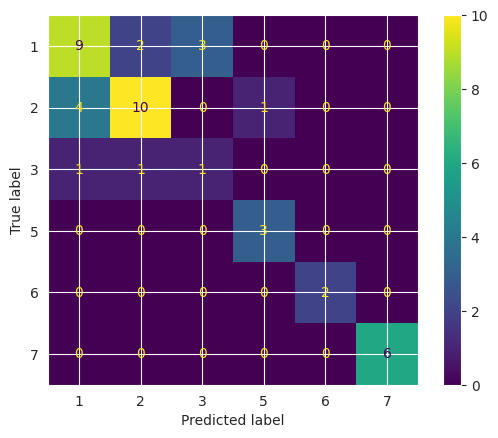

In [14]:
predictions = model.predict(X_test_glass)
print("\nTest results:")
print("\nClassification Report for Glass dataset:")
print(classification_report(y_test_glass, predictions))

cm = confusion_matrix(y_test_glass, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

b) companies

In [15]:
model = DecisionTreeClassifier()
model.fit(X_train_companies, y_train_companies)

DecisionTreeClassifier()


Test results:

Classification Report for Polish Bankruptcy dataset:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      8184
           1       0.51      0.56      0.53       417

    accuracy                           0.95      8601
   macro avg       0.74      0.77      0.75      8601
weighted avg       0.95      0.95      0.95      8601



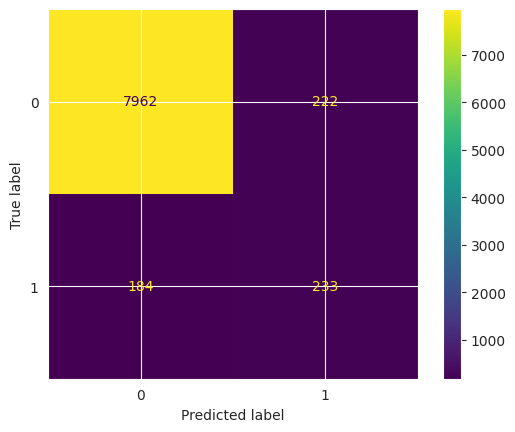

In [16]:
predictions = model.predict(X_test_companies)
print("\nTest results:")
print("\nClassification Report for Polish Bankruptcy dataset:")
print(classification_report(y_test_companies, predictions))

cm = confusion_matrix(y_test_companies, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

### Wstępne dostrojenie drzewa ze względu na parametr *max_depth*

a) glass

In [17]:
model = DecisionTreeClassifier()
model.fit(X_glass, y_glass)

DecisionTreeClassifier()

In [18]:
print("Głębokość drzewa:", model.get_depth())
print("Params:", model.get_params())

Głębokość drzewa: 12
Params: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': None, 'splitter': 'best'}


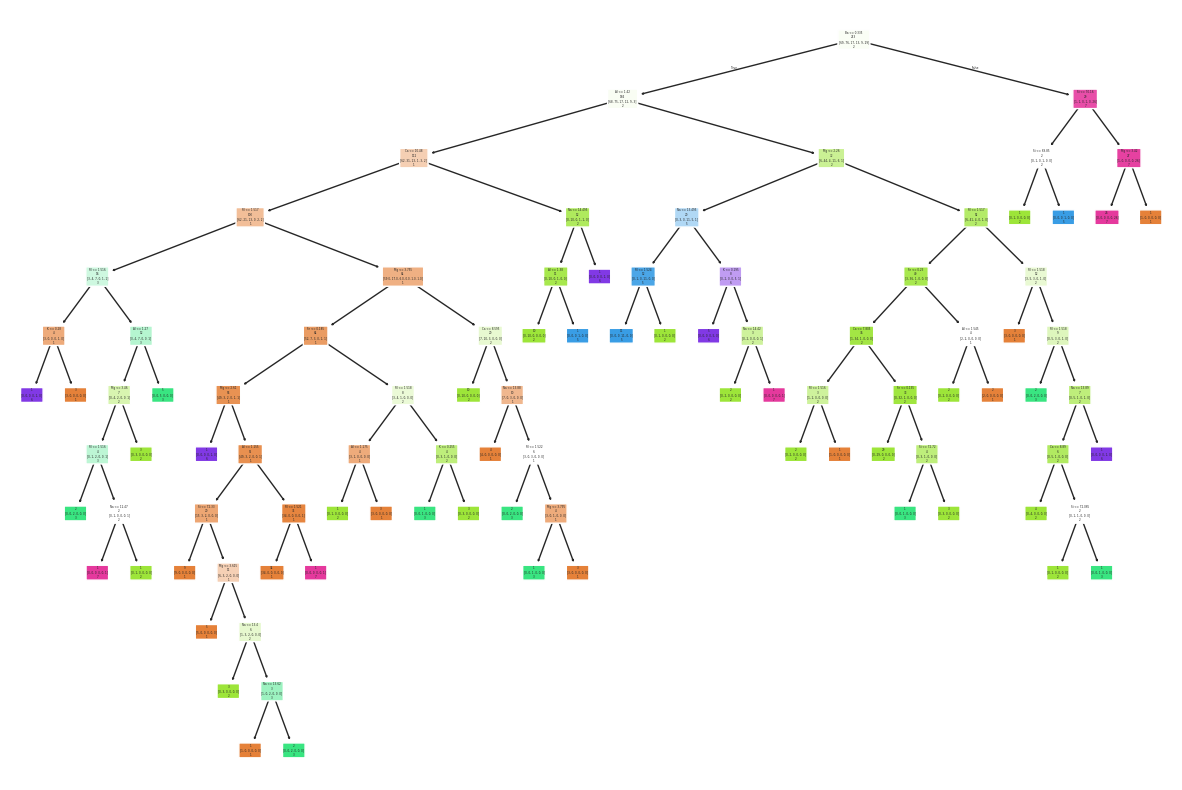

In [19]:
plt.figure(figsize=(15, 10))
plot_tree(model, filled=True, feature_names=X_glass.columns, class_names=[str(y) for y in y_glass.unique()], rounded=True,  fontsize=2, impurity=False, label='none')
plt.show()

In [28]:
depth_glass = [None, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
scores_glass = []
for d in depth_glass:
    cv = StratifiedKFold(n_splits=5, shuffle=True)
    model = DecisionTreeClassifier(max_depth=d)
    f1_scores = cross_val_score(model, X_glass, y_glass, cv=cv, scoring="f1_macro")
    scores_glass.append(f1_scores)

b) Companies

In [21]:
model = DecisionTreeClassifier()
model.fit(X_companies, y_companies)

DecisionTreeClassifier()

In [22]:
print("Głębokość drzewa:", model.get_depth())

Głębokość drzewa: 36


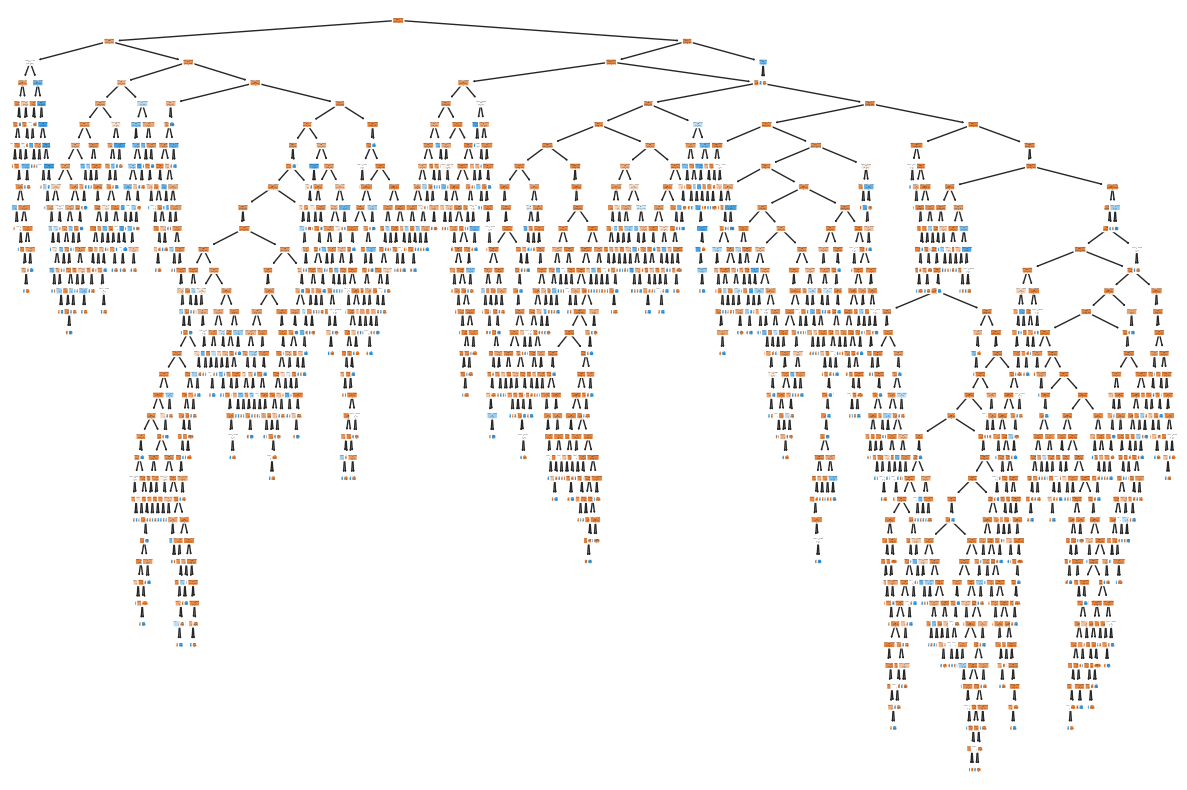

In [23]:
plt.figure(figsize=(15, 10))
plot_tree(model, filled=True, feature_names=X_companies.columns, class_names=[str(y) for y in y_companies.unique()], rounded=True, impurity=False, label='none')
plt.show()

In [26]:
depth = [None, 30, 25, 15, 10, 5]
scores = []

for d in depth:
    cv = StratifiedKFold(n_splits=5, shuffle=True)
    model = DecisionTreeClassifier(max_depth=d)
    f1_scores = cross_val_score(model, X_companies, y_companies, cv=cv, scoring="f1")
    scores.append(f1_scores)

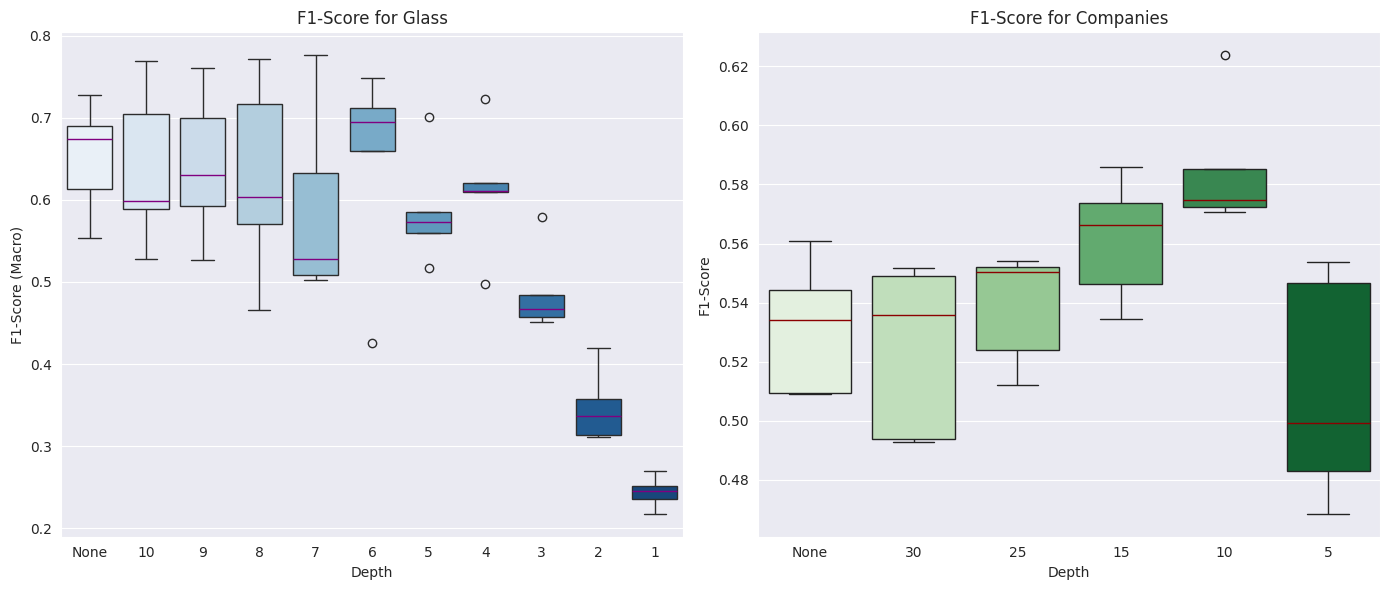

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.boxplot(ax=axes[0], data=scores_glass, palette="Blues", medianprops={'color': 'purple', 'ls': '-', 'lw': 1})
axes[0].set_xticks(range(len(depth_glass)))
axes[0].set_xticklabels([str(d) for d in depth_glass])
axes[0].set_title("F1-Score for Glass")
axes[0].set_xlabel("Depth")
axes[0].set_ylabel("F1-Score (Macro)")

sns.boxplot(ax=axes[1], data=scores, palette="Greens", medianprops={'color': 'darkred', 'ls': '-', 'lw': 1})
axes[1].set_xticks(range(len(depth)))
axes[1].set_xticklabels([str(d) for d in depth])
axes[1].set_title("F1-Score for Companies")
axes[1].set_xlabel("Depth")
axes[1].set_ylabel("F1-Score")

plt.tight_layout()
plt.show()

Na tej podstawie do dalszej analizy zbioru Companies wymieram parametr max_depth = 10, a dla zbioru Glass max_depth = 9

### Analiza wpływu hiperparametrów na wyniki modelu


#### a) min_samples_leaf

In [34]:
min_samples_leaf = [1, 5, 10, 15, 20]

In [83]:
precision_macro = make_scorer(precision_score, average="macro", zero_division=0)
recall_macro = make_scorer(recall_score, average="macro", zero_division=0)

scoring_glass = {
    "precision_macro": precision_macro,
    "recall_macro": recall_macro,
    "f1_macro": "f1_macro"
}

precision_binary = make_scorer(precision_score, average="binary", zero_division=0, pos_label=1)
recall_binary = make_scorer(recall_score, average="binary", zero_division=0, pos_label=1)
scoring_pcb = {
    "precision": precision_binary,
    "recall": recall_binary,
    "f1": "f1"
}

In [86]:
def create_metric_df(precision_scores, recall_scores, f1_scores, param_values, param_name, dataset_name):
    import pandas as pd

    def melt_scores(scores, metric_name):
        df = pd.DataFrame(scores).T.melt(var_name='param_index', value_name='score')
        df['Metric'] = metric_name
        return df

    precision_df = melt_scores(precision_scores, "Precision")
    recall_df = melt_scores(recall_scores, "Recall")
    f1_df = melt_scores(f1_scores, "F1")

    df = pd.concat([precision_df, recall_df, f1_df])

    df[param_name] = df['param_index'].map(lambda idx: param_values[idx])
    df['Dataset'] = dataset_name

    return df

In [95]:
def plot_metrics_layout(df1, df2, param_name):
    import matplotlib.pyplot as plt
    import seaborn as sns

    fig, ax = plt.subplots(2, 2, figsize=(16, 10), sharex=True, sharey='row')

    palette_glass = {"Precision": "lightblue", "Recall": "blue"}
    palette_pcb = {"Precision": "lightgreen", "Recall": "seagreen"}
    f1_color_glass = "lightblue"
    f1_color_pcb = "seagreen"

    df1_pr = df1[df1["Metric"].isin(["Precision", "Recall"])]
    df2_pr = df2[df2["Metric"].isin(["Precision", "Recall"])]
    df1_f1 = df1[df1["Metric"] == "F1"]
    df2_f1 = df2[df2["Metric"] == "F1"]

    sns.boxplot(
        ax=ax[0, 0],
        x=param_name,
        y="score",
        hue="Metric",
        data=df1_pr,
        palette=palette_glass,
        medianprops={'color': 'black'}
    )
    ax[0, 0].set_title(f"Precision & Recall – {df1['Dataset'].iloc[0]}")
    ax[0, 0].set_ylabel("Score")
    ax[0, 0].legend(title="Metric")

    sns.boxplot(
        ax=ax[0, 1],
        x=param_name,
        y="score",
        hue="Metric",
        data=df2_pr,
        palette=palette_pcb,
        medianprops={'color': 'black'}
    )
    ax[0, 1].set_title(f"Precision & Recall – {df2['Dataset'].iloc[0]}")
    ax[0, 1].set_ylabel("")
    ax[0, 1].legend(title="Metric")

    sns.boxplot(
        ax=ax[1, 0],
        x=param_name,
        y="score",
        data=df1_f1,
        color=f1_color_glass,
        medianprops={'color': 'black'}
    )
    ax[1, 0].set_title(f"F1-score – {df1['Dataset'].iloc[0]}")
    ax[1, 0].set_ylabel("F1 Score")

    sns.boxplot(
        ax=ax[1, 1],
        x=param_name,
        y="score",
        data=df2_f1,
        color=f1_color_pcb,
        medianprops={'color': 'black'}
    )
    ax[1, 1].set_title(f"F1-score – {df2['Dataset'].iloc[0]}")
    ax[1, 1].set_ylabel("")

    for a in ax[1]:
        a.set_xlabel(param_name)

    plt.tight_layout()
    plt.show()


In [84]:
precision_scores_glass_msl = []
recall_scores_glass_msl = []
f1_scores_glass_msl = []

for msl in min_samples_leaf:
    cv = StratifiedKFold(n_splits=5, shuffle=True)
    model = DecisionTreeClassifier(max_depth=9, min_samples_leaf=msl)
    scores = cross_validate(model, X_glass, y_glass, cv=cv, scoring=scoring_glass)

    precision_scores_glass_msl.append(scores["test_precision_macro"])
    recall_scores_glass_msl.append(scores["test_recall_macro"])
    f1_scores_glass_msl.append(scores["test_f1_macro"])

In [85]:
precision_scores_pcb_msl = []
recall_scores_pcb_msl = []
f1_scores_pcb_msl = []

for msl in min_samples_leaf:
    cv = StratifiedKFold(n_splits=5, shuffle=True)
    model = DecisionTreeClassifier(max_depth=10, min_samples_leaf=msl)
    scores = cross_validate(model, X_train_companies, y_train_companies, cv=cv, scoring=scoring_pcb)

    precision_scores_pcb_msl.append(scores["test_precision"])
    recall_scores_pcb_msl.append(scores["test_recall"])
    f1_scores_pcb_msl.append(scores["test_f1"])

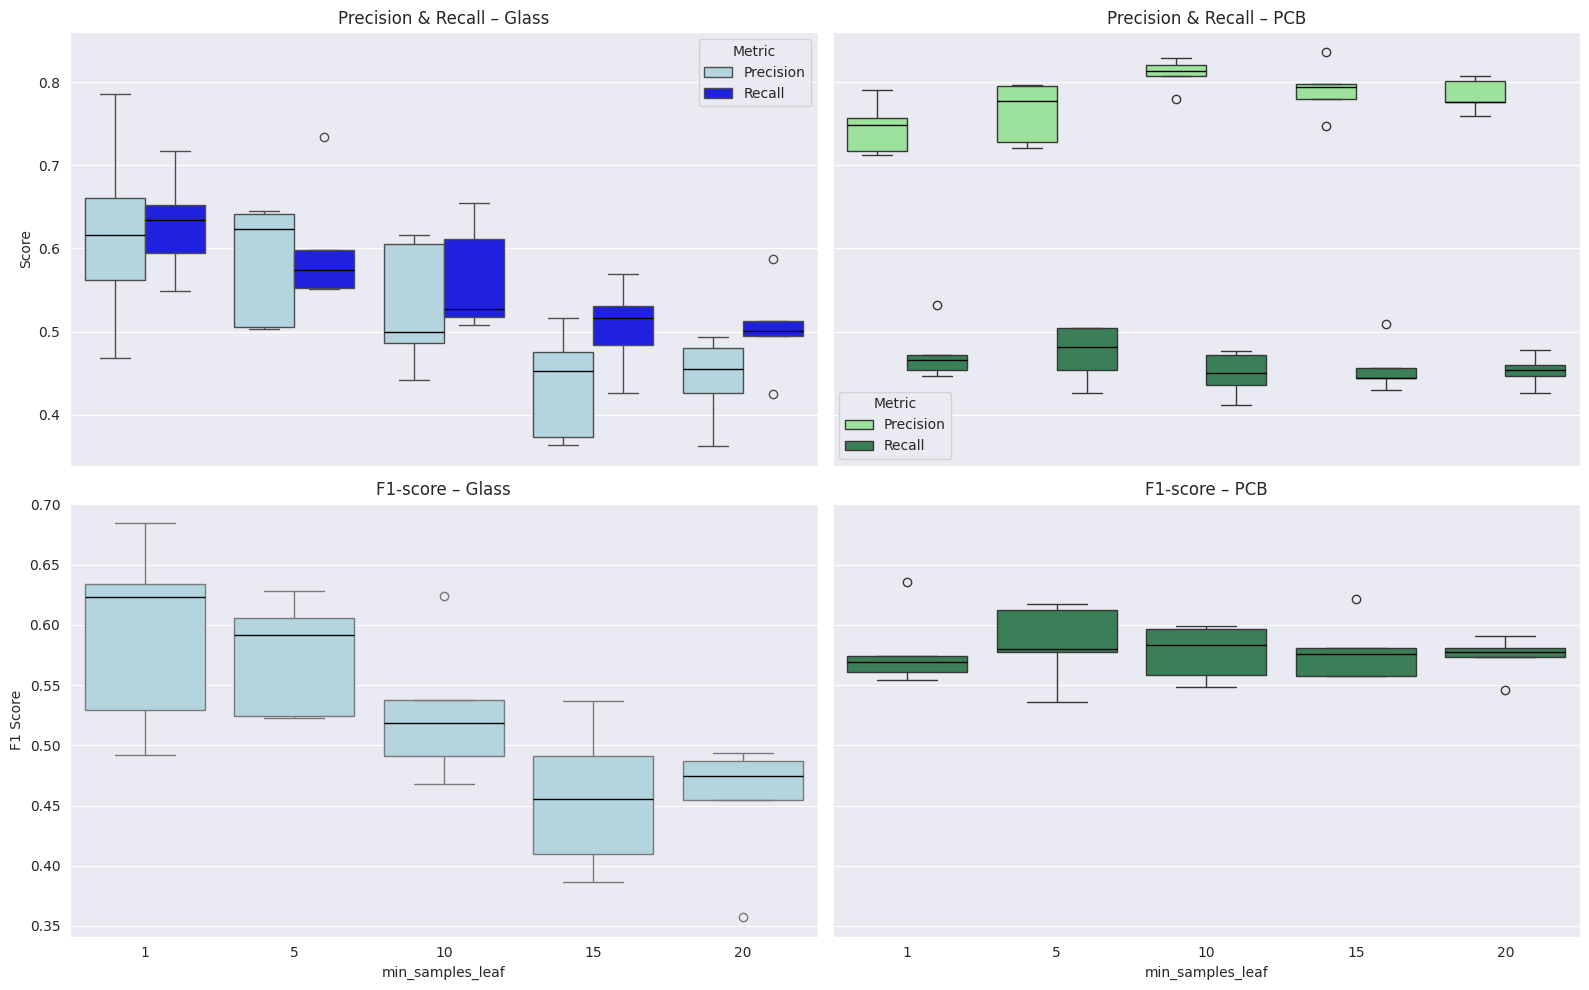

In [94]:
df_glass = create_metric_df(precision_scores_glass_msl, recall_scores_glass_msl, f1_scores_glass_msl, min_samples_leaf, "min_samples_leaf", "Glass")
df_pcb = create_metric_df(precision_scores_pcb_msl, recall_scores_pcb_msl, f1_scores_pcb_msl, min_samples_leaf, "min_samples_leaf", "PCB")

plot_metrics_layout(df_glass, df_pcb, "min_samples_leaf")

Widać, że dla zbioru Glass , przy większych ilościach próbek na liść otrzymujemy słabsze wyniki dla obydwu metryk. Wynika to z tego, że zbiór jest stosunkowo mały i przy większej ilości próbek na każdym liściu model słabiej dopasowuje się do problemu i mamy underfitting.

W przypadku zbioru Companies polepszyła nam się precyzja, przy niewielkim spadku czułości dla klasy mniejszościowej, przez co model częściej przewiduje przypadki prawdziwie pozytywne, wśród wszystkich przypadków zaklasyfikowanych jako pozytywne.

In [66]:
def compare_models(model_1, model_2, X_train, y_train, X_test, y_test, average="macro", pos_label=1):
    model_1.fit(X_train, y_train)
    pred_train_1 = model_1.predict(X_train)
    f1_train_1 = f1_score(pred_train_1, y_train, average=average, pos_label=pos_label)
    pred_test_1 = model_1.predict(X_test)
    f1_test_1 = f1_score(pred_test_1, y_test, average=average, pos_label=pos_label)
    model_2.fit(X_train, y_train)
    pred_train_2 = model_2.predict(X_train)
    f1_train_2 = f1_score(pred_train_2, y_train, average=average, pos_label=pos_label)
    pred_test_2 = model_2.predict(X_test)
    f1_test_2 = f1_score(pred_test_2, y_test, average=average, pos_label=pos_label)
    return f1_train_1, f1_test_1, f1_train_2, f1_test_2

In [78]:
model_1 = DecisionTreeClassifier(max_depth=9, min_samples_leaf=1)
model_2 = DecisionTreeClassifier(max_depth=9, min_samples_leaf=20)
f1_train_1, f1_test_1, f1_train_2, f1_test_2 = compare_models(model_1, model_2, X_train_glass, y_train_glass, X_test_glass, y_test_glass, average="macro")
f1_df_glass_msl = pd.DataFrame({
    "Min samples leaf": ["1", "10"],
    "F1 Score (Train)": [f1_train_1, f1_train_2],
    "F1 Score (Test)": [f1_test_1, f1_test_2]
})

print("Glass Dataset")
print(f1_df_glass_msl.to_string(index=False))

Glass Dataset
Min samples leaf  F1 Score (Train)  F1 Score (Test)
               1          0.974850         0.699819
              10          0.472406         0.503704


In [79]:
print("Companies Dataset")
model_1 = DecisionTreeClassifier(max_depth=10, min_samples_leaf=1)
model_2 = DecisionTreeClassifier(max_depth=10, min_samples_leaf=10)
f1_train_1, f1_test_1, f1_train_2, f1_test_2 = compare_models(model_1, model_2, X_train_companies, y_train_companies, X_test_companies, y_test_companies, average="binary", pos_label=1)
f1_df_pcb_msl = pd.DataFrame({
    "Min samples leaf": ["1", "20"],
    "F1 Score (Train)": [f1_train_1, f1_train_2],
    "F1 Score (Test)": [f1_test_1, f1_test_2]
})

print(f1_df_pcb_msl.to_string(index=False))

Companies Dataset
Min samples leaf  F1 Score (Train)  F1 Score (Test)
               1          0.736996         0.572687
              20          0.672869         0.558069


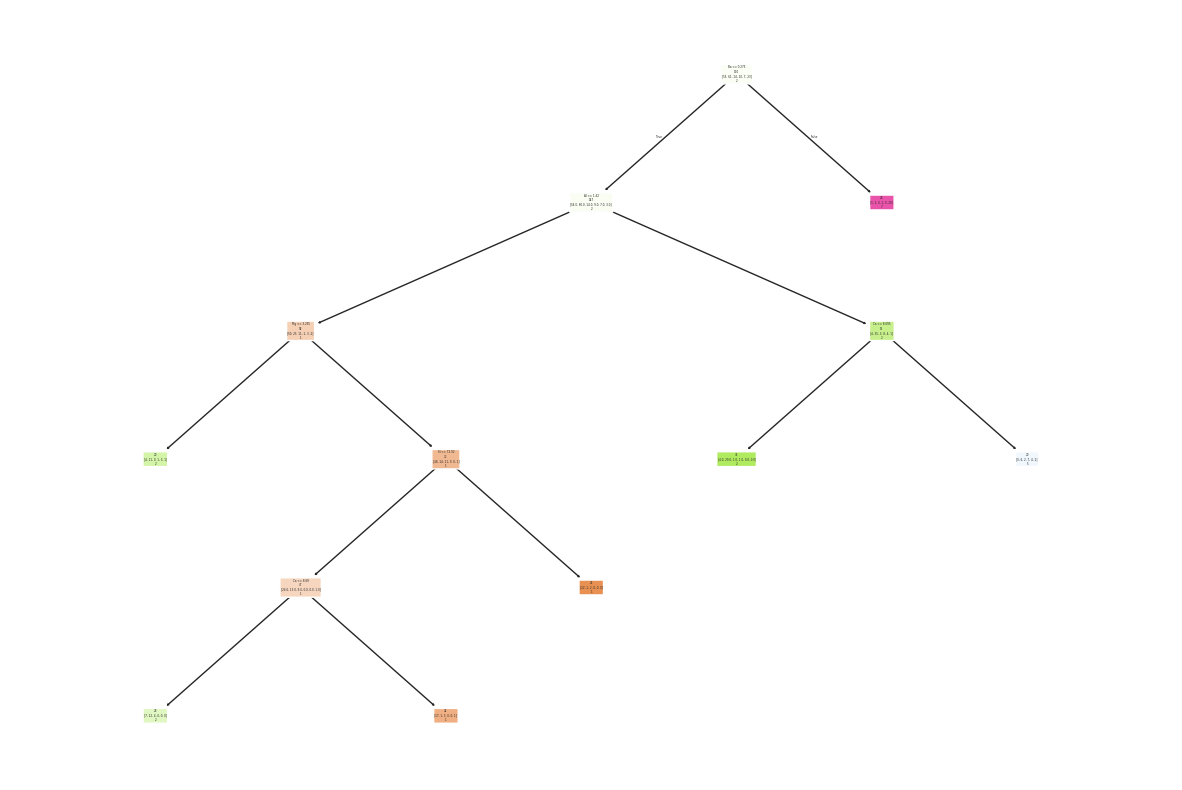

In [74]:
plt.figure(figsize=(15, 10))
plot_tree(model_2, filled=True, feature_names=X_glass.columns, class_names=[str(y) for y in y_glass.unique()], rounded=True,  fontsize=2, impurity=False, label='none')
plt.show()

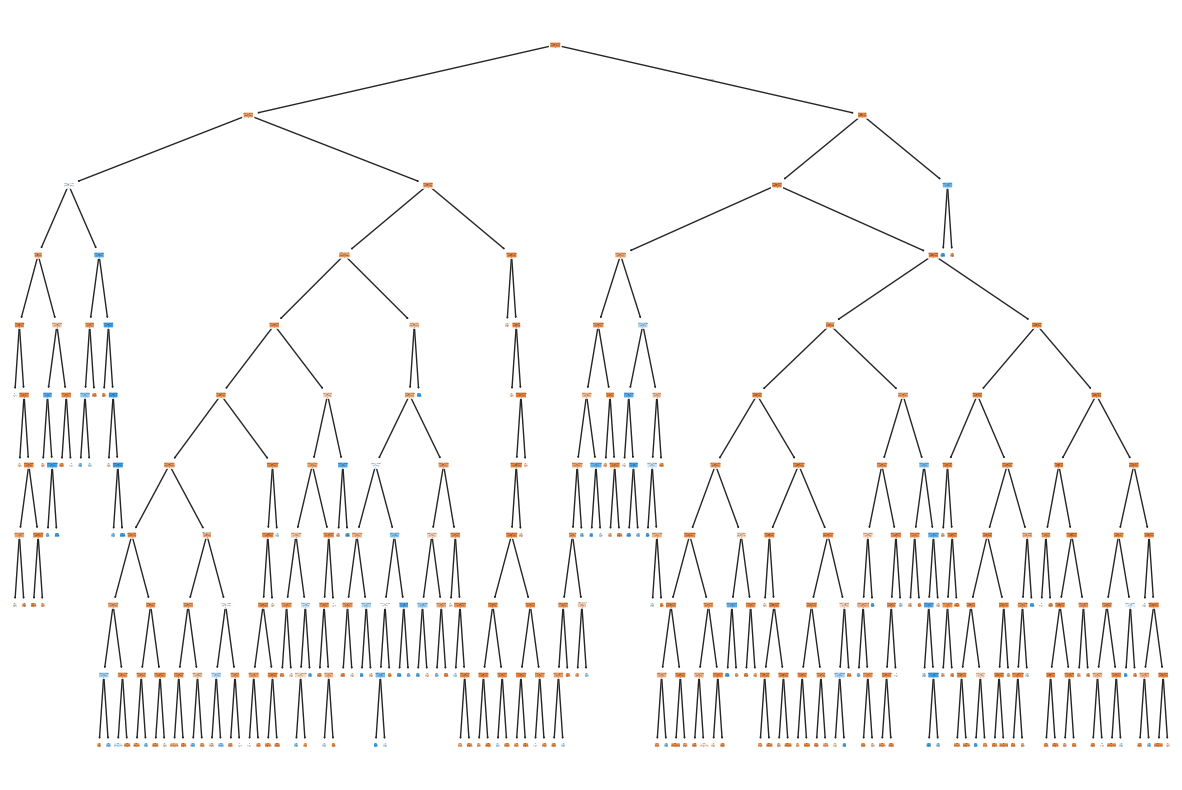

In [72]:
plt.figure(figsize=(15, 10))
plot_tree(model_2, filled=True, feature_names=X_companies.columns, class_names=[str(y) for y in y_companies.unique()], rounded=True, impurity=False, label='none')
plt.show()

#### b) cpp_alpha

In [80]:
ccp_alpha = [1, 5, 10, 15, 20]

In [147]:
model = DecisionTreeClassifier(max_depth=9)
path = model.cost_complexity_pruning_path(X_glass, y_glass)
ccp_alphas_glass = path.ccp_alphas
ccp_alphas_unique = np.unique(ccp_alphas_glass)
alpha_groups = np.array_split(ccp_alphas_unique, 4)
sampled_alphas_glass = [group[len(group) // 2] for group in alpha_groups]
sampled_alphas_glass.insert(0, 0.0)
sampled_alphas_glass.append(ccp_alphas_unique.max())
print("Liczba unikalnych wartości ccp_alpha:", len(ccp_alphas_unique))
print("Zakres ccp_alpha:", ccp_alphas_unique.min(), "-", ccp_alphas_unique.max())
print("ccp_alpha do przetestowania:", sampled_alphas_glass)

Liczba unikalnych wartości ccp_alpha: 30
Zakres ccp_alpha: 0.0 - 0.1221075800789021
ccp_alpha do przetestowania: [0.0, np.float64(0.006259780907668231), np.float64(0.008215962441314553), np.float64(0.01248958202171737), np.float64(0.040301810865191134), np.float64(0.1221075800789021)]


In [148]:
model = DecisionTreeClassifier(max_depth=15)
path = model.cost_complexity_pruning_path(X_companies, y_companies)
ccp_alphas_companies = path.ccp_alphas
ccp_alphas_unique = np.unique(ccp_alphas_companies)
alpha_groups = np.array_split(ccp_alphas_unique, 4)
sampled_alphas_companies = [group[len(group) // 2] for group in alpha_groups]
sampled_alphas_companies.insert(0, 0.0)
sampled_alphas_companies.append(ccp_alphas_unique.max())
print("Liczba unikalnych wartości ccp_alpha:", len(ccp_alphas_unique))
print("Zakres ccp_alpha:", ccp_alphas_unique.min(), "-", ccp_alphas_unique.max())
print("ccp_alpha do przetestowania:", sampled_alphas_companies)

Liczba unikalnych wartości ccp_alpha: 235
Zakres ccp_alpha: 0.0 - 0.006391834793196258
ccp_alpha do przetestowania: [0.0, np.float64(2.2872443432635287e-05), np.float64(4.456949741109357e-05), np.float64(7.705414295498936e-05), np.float64(0.000187062509113099), np.float64(0.006391834793196258)]


In [111]:
def plot_metrics_layout_ccp(df1, df2, param_name, tick_rotation=30, float_precision=3):
    import matplotlib.pyplot as plt
    import seaborn as sns

    fig, ax = plt.subplots(2, 2, figsize=(16, 10), sharey='row')

    palette_glass = {"Precision": "lightblue", "Recall": "blue"}
    palette_pcb = {"Precision": "lightgreen", "Recall": "seagreen"}
    f1_color_glass = "lightblue"
    f1_color_pcb = "seagreen"

    df1_pr = df1[df1["Metric"].isin(["Precision", "Recall"])]
    df2_pr = df2[df2["Metric"].isin(["Precision", "Recall"])]
    df1_f1 = df1[df1["Metric"] == "F1"]
    df2_f1 = df2[df2["Metric"] == "F1"]

    sns.boxplot(
        ax=ax[0, 0],
        x=param_name,
        y="score",
        hue="Metric",
        data=df1_pr,
        palette=palette_glass,
        medianprops={'color': 'black'}
    )
    ax[0, 0].set_title(f"Precision & Recall – {df1['Dataset'].iloc[0]}")
    ax[0, 0].set_ylabel("Score")
    ax[0, 0].legend(title="Metric")
    ax[0, 0].set_xticklabels(
        [f"{float(label.get_text()):.{float_precision}f}" for label in ax[0, 0].get_xticklabels()],
        rotation=tick_rotation
    )

    sns.boxplot(
        ax=ax[0, 1],
        x=param_name,
        y="score",
        hue="Metric",
        data=df2_pr,
        palette=palette_pcb,
        medianprops={'color': 'black'}
    )
    ax[0, 1].set_title(f"Precision & Recall – {df2['Dataset'].iloc[0]}")
    ax[0, 1].set_ylabel("")
    ax[0, 1].legend(title="Metric")
    ax[0, 1].set_xticklabels(
        [f"{float(label.get_text()):.{float_precision}f}" for label in ax[0, 1].get_xticklabels()],
        rotation=tick_rotation
    )

    sns.boxplot(
        ax=ax[1, 0],
        x=param_name,
        y="score",
        data=df1_f1,
        color=f1_color_glass,
        medianprops={'color': 'black'}
    )
    ax[1, 0].set_title(f"F1-score – {df1['Dataset'].iloc[0]}")
    ax[1, 0].set_ylabel("F1 Score")
    ax[1, 0].set_xticklabels(
        [f"{float(label.get_text()):.{float_precision}f}" for label in ax[1, 0].get_xticklabels()],
        rotation=tick_rotation
    )

    sns.boxplot(
        ax=ax[1, 1],
        x=param_name,
        y="score",
        data=df2_f1,
        color=f1_color_pcb,
        medianprops={'color': 'black'}
    )
    ax[1, 1].set_title(f"F1-score – {df2['Dataset'].iloc[0]}")
    ax[1, 1].set_ylabel("")
    ax[1, 1].set_xticklabels(
        [f"{float(label.get_text()):.{float_precision}f}" for label in ax[1, 1].get_xticklabels()],
        rotation=tick_rotation
    )

    for a in ax[1]:
        a.set_xlabel(param_name)

    plt.tight_layout()
    plt.show()


In [96]:
precision_scores_glass_ccp = []
recall_scores_glass_ccp = []
f1_scores_glass_msl_ccp = []

for ccp in sampled_alphas_glass:
    cv = StratifiedKFold(n_splits=5, shuffle=True)
    model = DecisionTreeClassifier(max_depth=9, ccp_alpha=ccp)
    scores = cross_validate(model, X_glass, y_glass, cv=cv, scoring=scoring_glass)
    precision_scores_glass_ccp.append(scores["test_precision_macro"])
    recall_scores_glass_ccp.append(scores["test_recall_macro"])
    f1_scores_glass_msl_ccp.append(scores["test_f1_macro"])

In [99]:
precision_scores_pcb_ccp = []
recall_scores_pcb_ccp = []
f1_scores_pcb_ccp = []

for ccp in sampled_alphas_companies:
    cv = StratifiedKFold(n_splits=5, shuffle=True)
    model = DecisionTreeClassifier(max_depth=10, ccp_alpha=ccp)
    scores = cross_validate(model, X_train_companies, y_train_companies, cv=cv, scoring=scoring_pcb)

    precision_scores_pcb_ccp.append(scores["test_precision"])
    recall_scores_pcb_ccp.append(scores["test_recall"])
    f1_scores_pcb_ccp.append(scores["test_f1"])

/tmp/ipykernel_1096711/4022562915.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0, 0].set_xticklabels(
/tmp/ipykernel_1096711/4022562915.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0, 1].set_xticklabels(
/tmp/ipykernel_1096711/4022562915.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1, 0].set_xticklabels(
/tmp/ipykernel_1096711/4022562915.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1, 1].set_xticklabels(


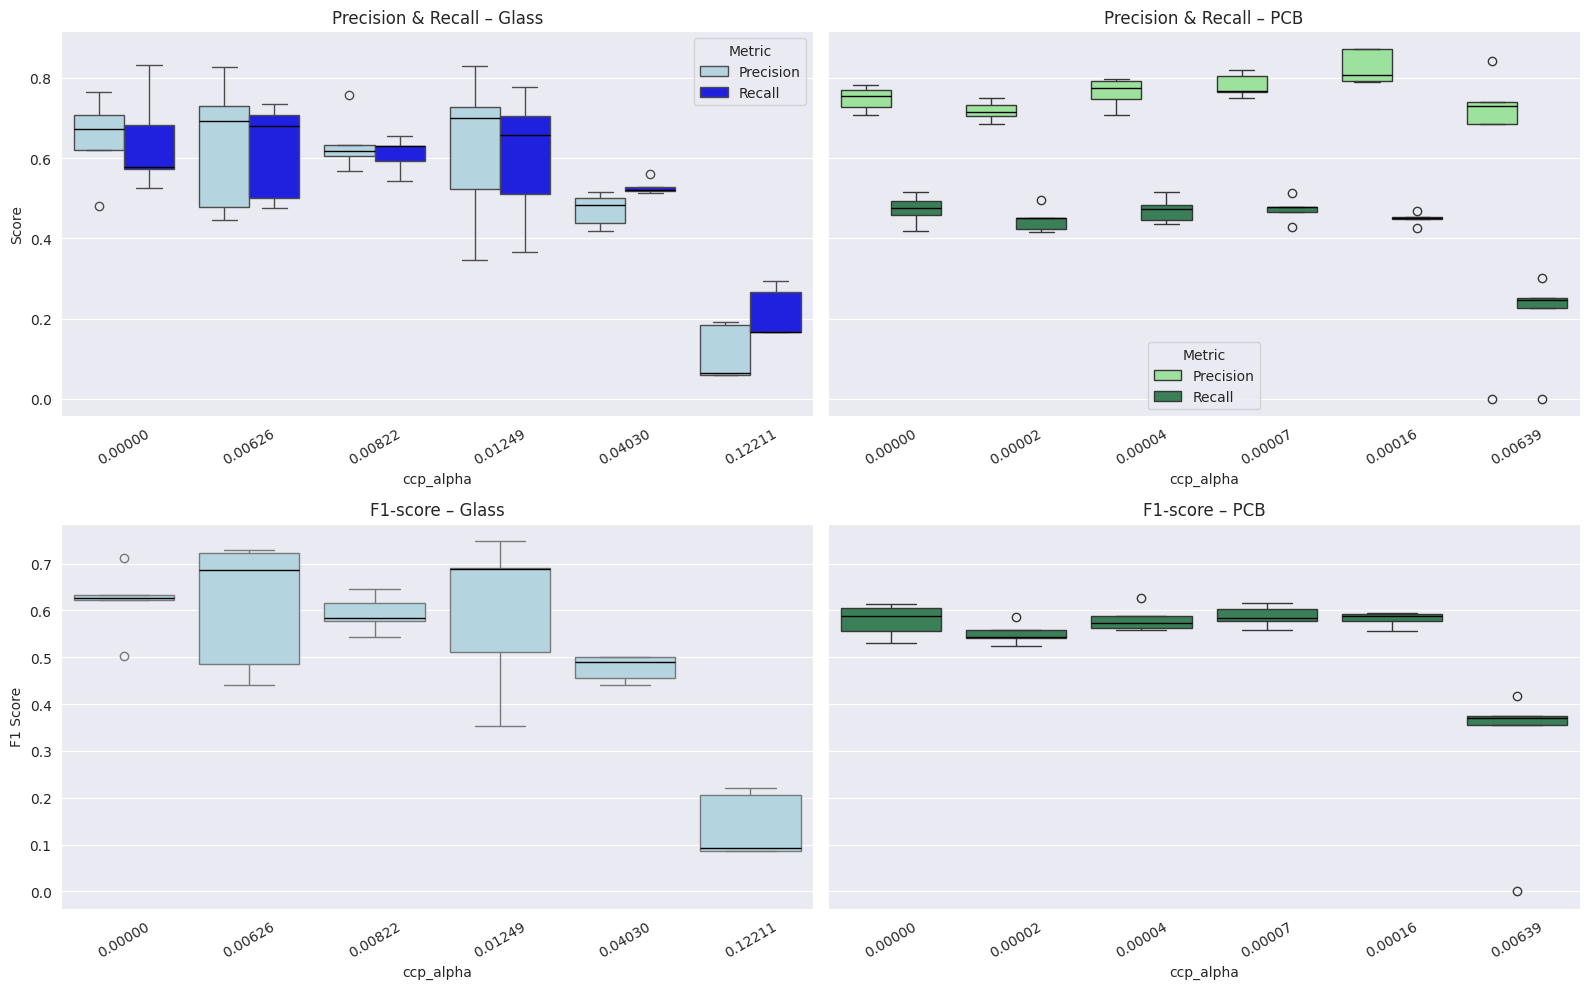

In [112]:
df_glass_ccp = create_metric_df(precision_scores_glass_ccp, recall_scores_glass_ccp, f1_scores_glass_msl_ccp, sampled_alphas_glass, "ccp_alpha", "Glass")
df_pcb_ccp = create_metric_df(precision_scores_pcb_ccp, recall_scores_pcb_ccp, f1_scores_pcb_ccp, sampled_alphas_companies, "ccp_alpha", "PCB")

plot_metrics_layout_ccp(df_glass_ccp, df_pcb_ccp, "ccp_alpha", tick_rotation=30, float_precision=5)

W przypadku zbioru Glass delikatny prunning powoduje polepszenie zdolności generalizacji modelu, natomiast coraz większy powoduje znaczne jego pogorszenie. Spowodowane jest to tym, że zbiór danych jest stosunkowo mały, więc zbyt mocne przycinanie drzewa znacznie ogranicza jego mozliwości.

Dla zbioru Companies stopniowy prunning również polepsza wyniki. Tutaj możliwy jest intensywniejszy prunning, ze względu na rozmiary i złożoność danych. Również tutaj dla zbyt dużego przycinania zdolności modelu znacznie spadają.

In [113]:
model_1 = DecisionTreeClassifier(max_depth=9, ccp_alpha=sampled_alphas_glass[1])
model_2 = DecisionTreeClassifier(max_depth=9, ccp_alpha=sampled_alphas_glass[-2])
f1_train_1, f1_test_1, f1_train_2, f1_test_2 = compare_models(model_1, model_2, X_train_glass, y_train_glass, X_test_glass, y_test_glass, average="macro")
f1_df_glass_ccp = pd.DataFrame({
    "Ccp alpha": [sampled_alphas_glass[1], sampled_alphas_glass[-2]],
    "F1 Score (Train)": [f1_train_1, f1_train_2],
    "F1 Score (Test)": [f1_test_1, f1_test_2]
})

print("Glass Dataset")
print(f1_df_glass_ccp.to_string(index=False))

Glass Dataset
 Ccp alpha  F1 Score (Train)  F1 Score (Test)
  0.006260          0.927380         0.750000
  0.040302          0.502481         0.510101


In [115]:
print("Companies Dataset")
model_1 = DecisionTreeClassifier(max_depth=15, ccp_alpha=sampled_alphas_companies[1])
model_2 = DecisionTreeClassifier(max_depth=15, ccp_alpha=sampled_alphas_companies[-2])
f1_train_1, f1_test_1, f1_train_2, f1_test_2 = compare_models(model_1, model_2, X_train_companies, y_train_companies, X_test_companies, y_test_companies, average="binary", pos_label=1)
f1_df_pcb_ccp = pd.DataFrame({
    "Ccp alpha": [sampled_alphas_companies[1], sampled_alphas_companies[-2]],
    "F1 Score (Train)": [f1_train_1, f1_train_2],
    "F1 Score (Test)": [f1_test_1, f1_test_2]
})

print(f1_df_pcb_ccp.to_string(index=False))

Companies Dataset
 Ccp alpha  F1 Score (Train)  F1 Score (Test)
  0.000023          0.877052         0.562334
  0.000161          0.671505         0.593509


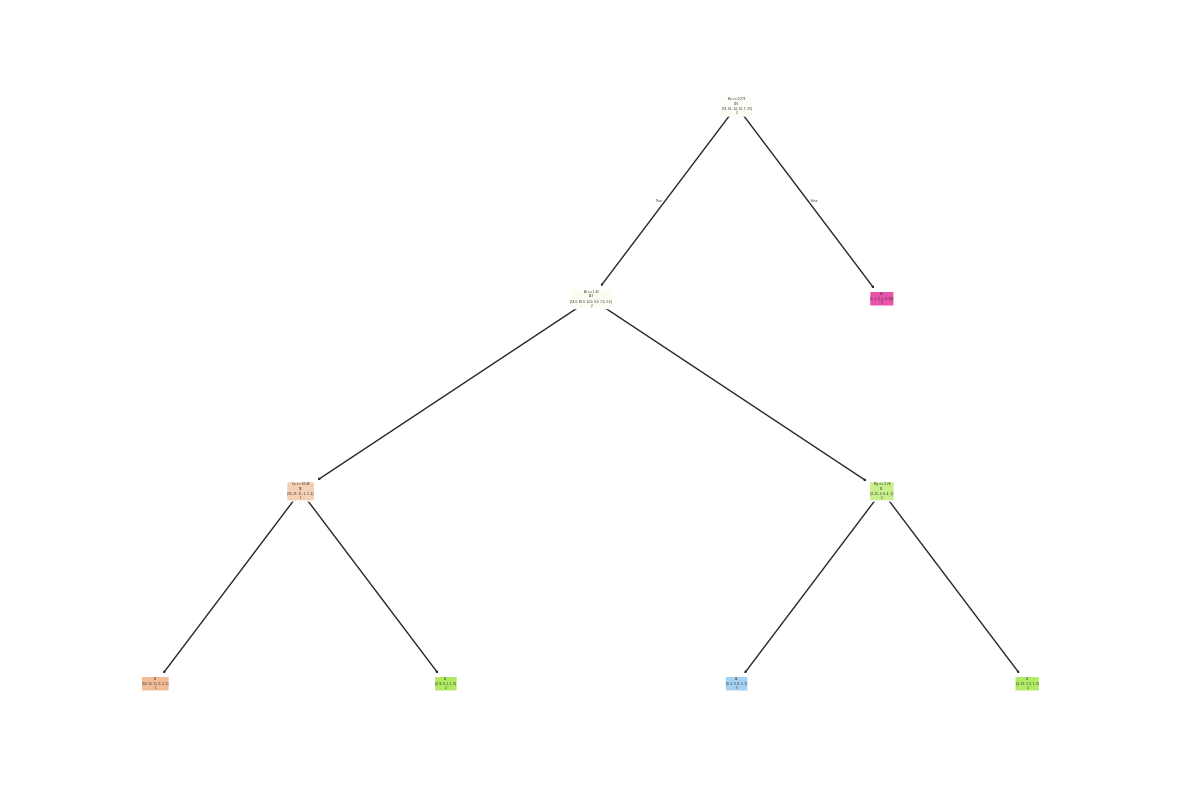

In [114]:
plt.figure(figsize=(15, 10))
plot_tree(model_2, filled=True, feature_names=X_glass.columns, class_names=[str(y) for y in y_glass.unique()], rounded=True,  fontsize=2, impurity=False, label='none')
plt.show()

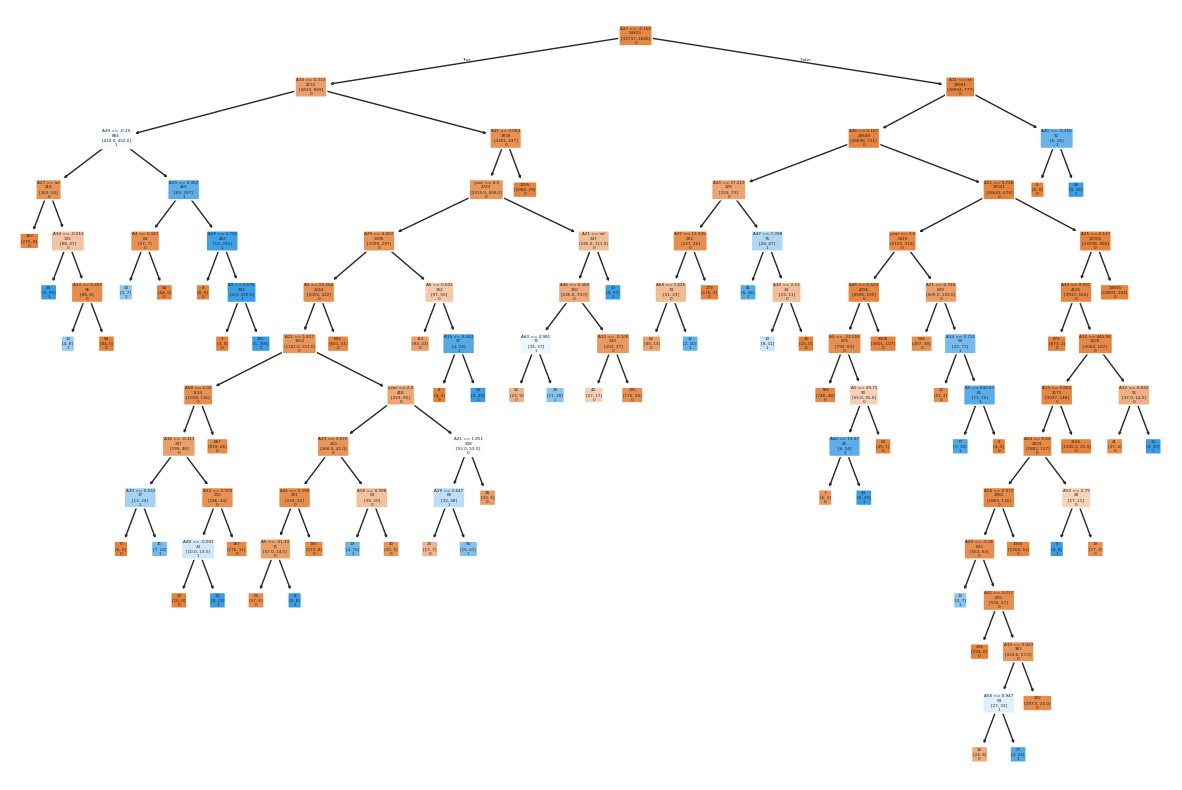

In [116]:
plt.figure(figsize=(15, 10))
plot_tree(model_2, filled=True, feature_names=X_companies.columns, class_names=[str(y) for y in y_companies.unique()], rounded=True, impurity=False, label='none', fontsize=3)
plt.show()

#### c) criterion

In [117]:
criterion = ["gini", "entropy", "log_loss"]

In [121]:
precision_scores_glass_crit = []
recall_scores_glass_crit = []
f1_scores_glass_msl_crit = []

for crit in criterion:
    cv = StratifiedKFold(n_splits=5, shuffle=True)
    model = DecisionTreeClassifier(max_depth=9, criterion=crit)
    scores = cross_validate(model, X_glass, y_glass, cv=cv, scoring=scoring_glass)
    precision_scores_glass_crit.append(scores["test_precision_macro"])
    recall_scores_glass_crit.append(scores["test_recall_macro"])
    f1_scores_glass_msl_crit.append(scores["test_f1_macro"])

In [122]:
precision_scores_pcb_crit = []
recall_scores_pcb_crit = []
f1_scores_pcb_crit = []

for crit in criterion:
    cv = StratifiedKFold(n_splits=5, shuffle=True)
    model = DecisionTreeClassifier(max_depth=10, criterion=crit)
    scores = cross_validate(model, X_train_companies, y_train_companies, cv=cv, scoring=scoring_pcb)
    precision_scores_pcb_crit.append(scores["test_precision"])
    recall_scores_pcb_crit.append(scores["test_recall"])
    f1_scores_pcb_crit.append(scores["test_f1"])

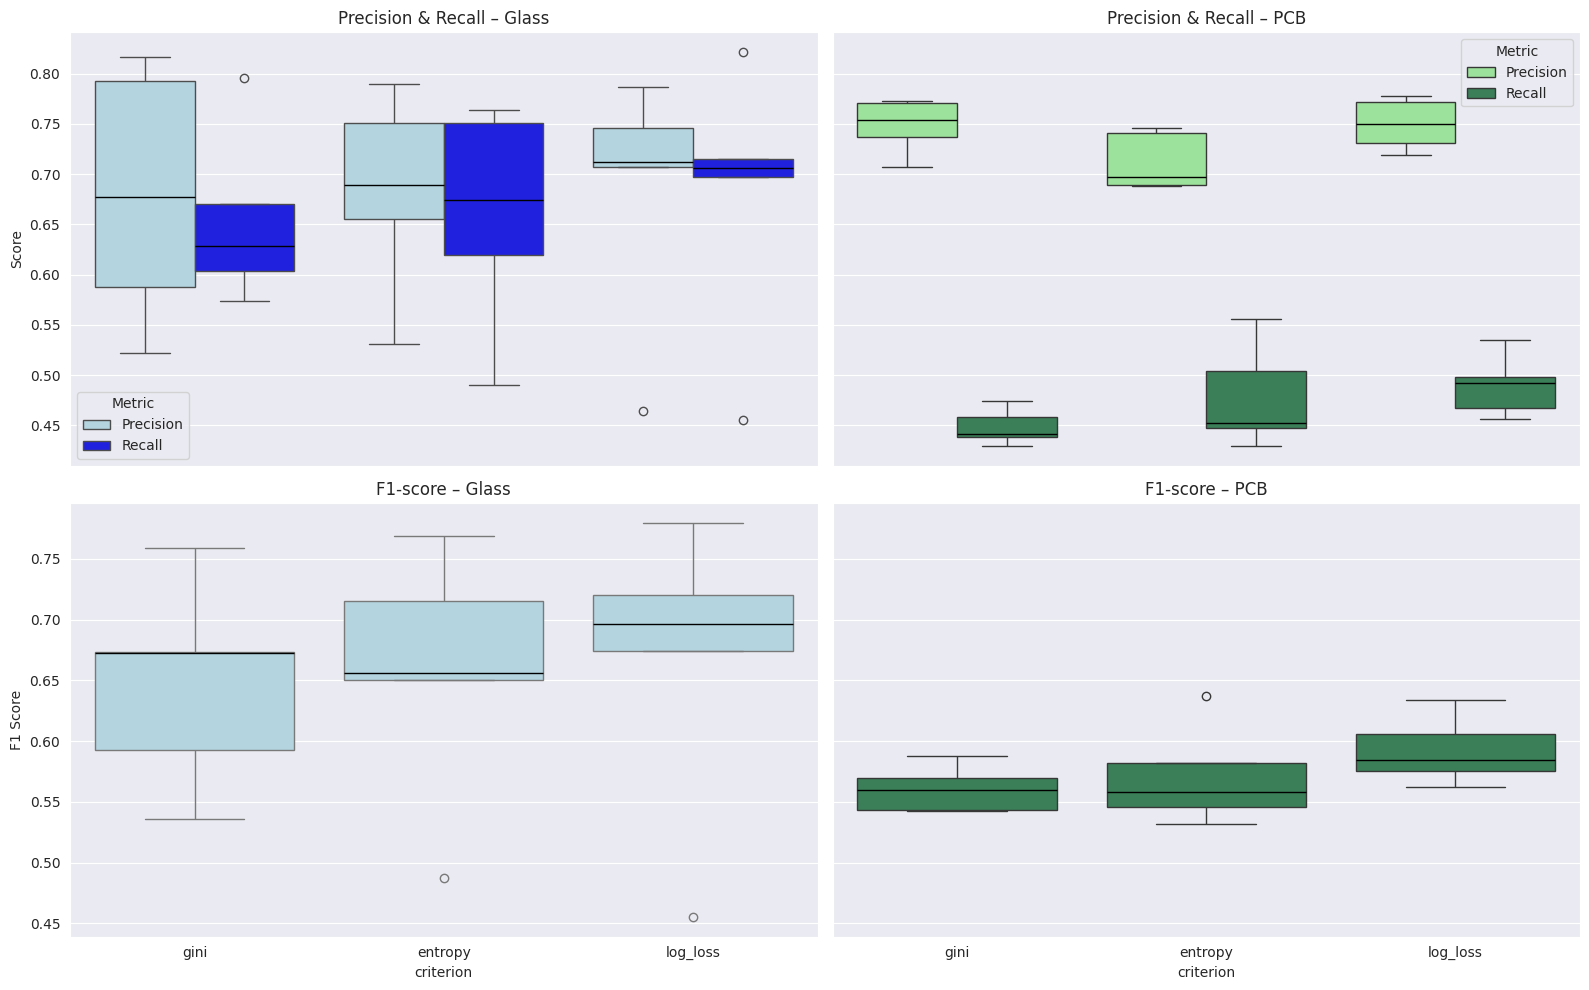

In [123]:
df_glass = create_metric_df(precision_scores_glass_crit, recall_scores_glass_crit, f1_scores_glass_msl_crit, criterion, "criterion", "Glass")
df_pcb = create_metric_df(precision_scores_pcb_crit, recall_scores_pcb_crit, f1_scores_pcb_crit, criterion, "criterion", "PCB")

plot_metrics_layout(df_glass, df_pcb, "criterion")

### Różnica między zwykłą walidacją krzyżową a stratyfikowaną

In [124]:
cv = KFold(n_splits=5, shuffle=True)
model = DecisionTreeClassifier(max_depth=9)
cv_scores_glass = cross_val_score(model, X_glass, y_glass, cv=cv, scoring="f1_macro")
strat_cv = StratifiedKFold(n_splits=5, shuffle=True)
model = DecisionTreeClassifier(max_depth=9)
strat_cv_scores_glass = cross_val_score(model, X_glass, y_glass, cv=strat_cv, scoring="f1_macro")

In [126]:
cv = KFold(n_splits=5, shuffle=True)
model = DecisionTreeClassifier(max_depth=10)
cv_scores_companies = cross_val_score(model, X_companies, y_companies, cv=cv, scoring="f1")
strat_cv = StratifiedKFold(n_splits=5, shuffle=True)
model = DecisionTreeClassifier(max_depth=10)
strat_cv_scores_companies = cross_val_score(model, X_companies, y_companies, cv=strat_cv, scoring="f1")

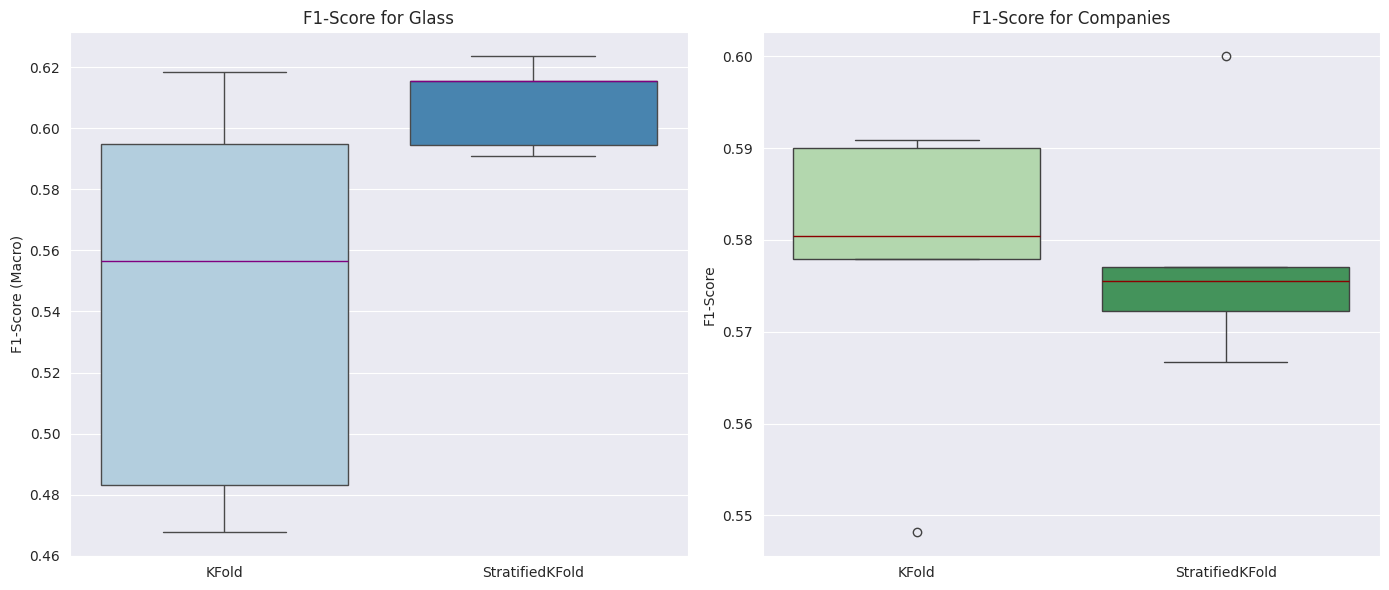

In [127]:
_, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.boxplot(ax=axes[0], data=[cv_scores_glass, strat_cv_scores_glass], palette="Blues", medianprops={'color': 'purple', 'ls': '-', 'lw': 1})
axes[0].set_xticks(range(2))
axes[0].set_xticklabels(["KFold", "StratifiedKFold"])
axes[0].set_title("F1-Score for Glass")
axes[0].set_ylabel("F1-Score (Macro)")

sns.boxplot(ax=axes[1], data=[cv_scores_companies, strat_cv_scores_companies], palette="Greens", medianprops={'color': 'darkred', 'ls': '-', 'lw': 1})
axes[1].set_xticks(range(2))
axes[1].set_xticklabels(["KFold", "StratifiedKFold"])
axes[1].set_title("F1-Score for Companies")
axes[1].set_ylabel("F1-Score")

plt.tight_layout()
plt.show()

Dla obydwu zbiorów stabilniejsze wyniki dała walidacja krzyżowa stratyfikowana. Dzięki zachowaniu dystrybucji klas pomiędzy różnymi foldami możemy wnioskować jak prawdopodobnie będzie zachowywał się model dla całego zbioru danych oraz ograniczamy ryzyko, w którym powstałby fold gdzie do treningu wykorzystane są próbki z tylko jednej klasy a do walidacji próbki z drugiej co znacznie zaniżyłoby wyniki. Dla zbioru glass, który jest zbalansowany, lepsza dystrybucja klas pomiędzy foldami dała lepsze rezultaty, natomiast w przypadku zbioru companies, uzyskaliśmy wyniki trochę niższe, co jest również spodziewane, bo w całym zbiorze dominuje klasa pierwsza, więc wyniki F1 dla klasy drugiej będą słabsze.

### Analiza wyników w zależności od zastosowania parametru *class_weight* - zbiór Companies

In [129]:
class_weight = [None, {0: 1, 1: 2}, {0: 1, 1: 5}, {0: 1, 1: 10}, {0: 1, 1: 20}, "balanced"]

In [131]:
precision_scores_pcb_weight = []
recall_scores_pcb_weight = []
f1_scores_pcb_weight = []

for weight in class_weight:
    cv = StratifiedKFold(n_splits=5, shuffle=True)
    model = DecisionTreeClassifier(max_depth=10, class_weight=weight)
    scores = cross_validate(model, X_train_companies, y_train_companies, cv=cv, scoring=scoring_pcb)
    precision_scores_pcb_weight.append(scores["test_precision"])
    recall_scores_pcb_weight.append(scores["test_recall"])
    f1_scores_pcb_weight.append(scores["test_f1"])

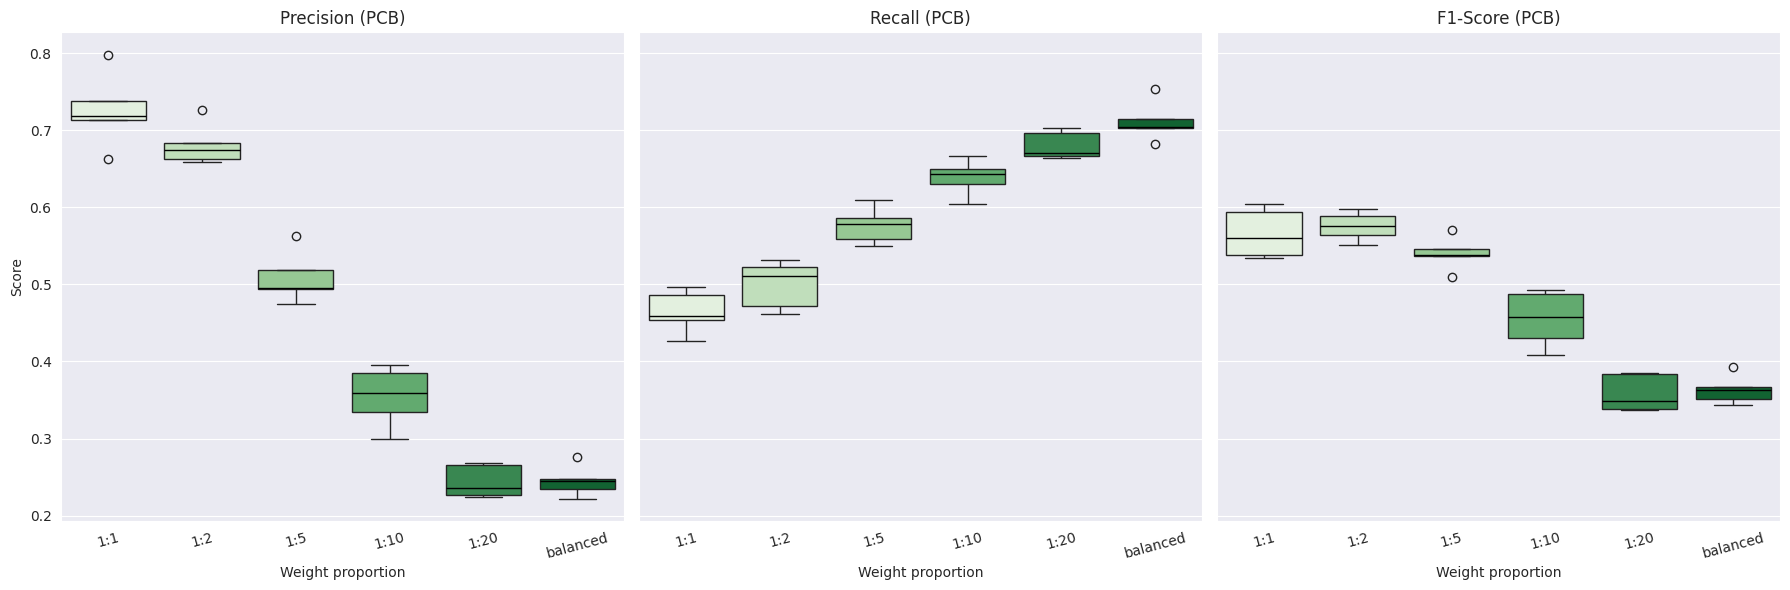

In [134]:
import matplotlib.pyplot as plt
import seaborn as sns

class_weight_labels = ["1:1", "1:2", "1:5", "1:10", "1:20", "balanced"]

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

sns.boxplot(
    ax=axes[0],
    data=precision_scores_pcb_weight,
    palette="Greens",
    medianprops={'color': 'black'}
)
axes[0].set_title("Precision (PCB)")
axes[0].set_xlabel("Weight proportion")
axes[0].set_ylabel("Score")
axes[0].set_xticks(range(len(class_weight_labels)))
axes[0].set_xticklabels(class_weight_labels, rotation=15)

sns.boxplot(
    ax=axes[1],
    data=recall_scores_pcb_weight,
    palette="Greens",
    medianprops={'color': 'black'}
)
axes[1].set_title("Recall (PCB)")
axes[1].set_xlabel("Weight proportion")
axes[1].set_xticks(range(len(class_weight_labels)))
axes[1].set_xticklabels(class_weight_labels, rotation=15)

sns.boxplot(
    ax=axes[2],
    data=f1_scores_pcb_weight,
    palette="Greens",
    medianprops={'color': 'black'}
)
axes[2].set_title("F1-Score (PCB)")
axes[2].set_xlabel("Weight proportion")
axes[2].set_xticks(range(len(class_weight_labels)))
axes[2].set_xticklabels(class_weight_labels, rotation=15)

plt.tight_layout()
plt.show()


Wraz ze wzrostem proporcji na korzyść klasy mniej licznej, spada precyzja, natomiast rośnie czułość. Możemy wnioskować że model gorzej rozpoznaje przypadki prawdziwie pozytywne wśród wszystkich przypadków pozytywnie okreslonych, natomiast lepiej rozpoznaje przypadki pozytywne wśród wszystkich pozytywnych przypadków dla klasy mniej licznej.